## Loading data with yt_xarray 

This notebook demonstrates how to initialize a yt dataset object from an open xarray dataset.

After describing the sample data that is used, the notebook covers:

* [Loading all fields](#Loading-all-fields)
* [Overview of yt datasets](#A-brief-overview-of-yt-datasets)
* [Loading a subset of fields](#Loading-a-subset-of-fields)
* [Loading method and memory usage](#Loading-method-and-memory-usage)


### sample data

We'll be using some random sample data in this notebook (as well as many of the others), generated from a convenience function, `yt_xarray.sample_data.load_random_xr_data()`. To use it, we have to supply two dictionaries: one containing fieldnames mapped to the dimension names and a second containing the starting value, end value and number of elements for each dimension:




In [1]:
from yt_xarray.sample_data import load_random_xr_data

fields = {'temperature': ('x', 'y', 'z'), 'pressure': ('x', 'y', 'z')}
dims = {'x': (0,1,15), 'y': (0, 1, 10), 'z': (0, 1, 15)}
ds = load_random_xr_data(fields, dims, length_unit='m')
ds

<xarray.Dataset>
Dimensions:      (x: 15, y: 10, z: 15)
Coordinates:
  * x            (x) float64 0.0 0.07143 0.1429 0.2143 ... 0.8571 0.9286 1.0
  * y            (y) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * z            (z) float64 0.0 0.07143 0.1429 0.2143 ... 0.8571 0.9286 1.0
Data variables:
    temperature  (x, y, z) float64 0.7337 0.2377 0.9107 ... 0.3052 0.8424 0.615
    pressure     (x, y, z) float64 0.8171 0.6735 0.5087 ... 0.5845 0.2743 0.3072
Attributes:
    geospatial_vertical_units:  m

While we're using random sample data here, note that yt_xarray provides a simple wrapper of the standard xarray `open_dataset` function that will check yt's `test_data_dir` for data if the file is not found in the local path. It is used in the same way as xarray:

```python
ds = yt_xarray.open_dataset("path/to/your/dataset.nc")
```



### Loading all fields

The primary way of loading data into yt is by creation of a yt dataset object. 

To create a yt dataset that loads all the data variables:

In [2]:
import yt_xarray
import yt

yt_ds = ds.yt.load_grid()

yt_xarray : [INFO ] 2023-02-06 12:24:07,825:  Inferred geometry type is cartesian. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2023-02-06 12:24:07,826:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 12:24:07,827:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2023-02-06 12:24:07,927 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 12:24:07,928 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-02-06 12:24:07,929 Parameters: domain_left_edge          = [-0.03571429 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 12:24:07,930 Parameters: domain_right_edge         = [1.03571429 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 12:24:07,931 Parameters: cosmological_simulation   = 0


note that this yt dataset actually maintains references to the open xarray dataset! Data will be loaded into yt only as needed. 


### A brief overview of yt datasets

Now that we have a yt dataset, let's do a quick overview of a yt dataset:


**Field Tuples**

You can check the available fields in a yt dataset with:

In [3]:
yt_ds.field_list

[('stream', 'pressure'), ('stream', 'temperature')]

fields in yt include both a field type and a field name. yt_xarray relies on yt's "stream" frontend infrastructure, so all of our xarray fields end up with a field type of "stream". This is important because when referring to fields, you'll need to supply both the field type and the field name. 

To construct a `SlicePlot`, for example:

yt : [INFO     ] 2023-02-06 12:24:08,113 xlim = -0.035714 1.035714
yt : [INFO     ] 2023-02-06 12:24:08,114 ylim = -0.055556 1.055556
yt : [INFO     ] 2023-02-06 12:24:08,115 xlim = -0.035714 1.035714
yt : [INFO     ] 2023-02-06 12:24:08,115 ylim = -0.055556 1.055556
yt : [INFO     ] 2023-02-06 12:24:08,121 Making a fixed resolution buffer of (('stream', 'temperature')) 800 by 800



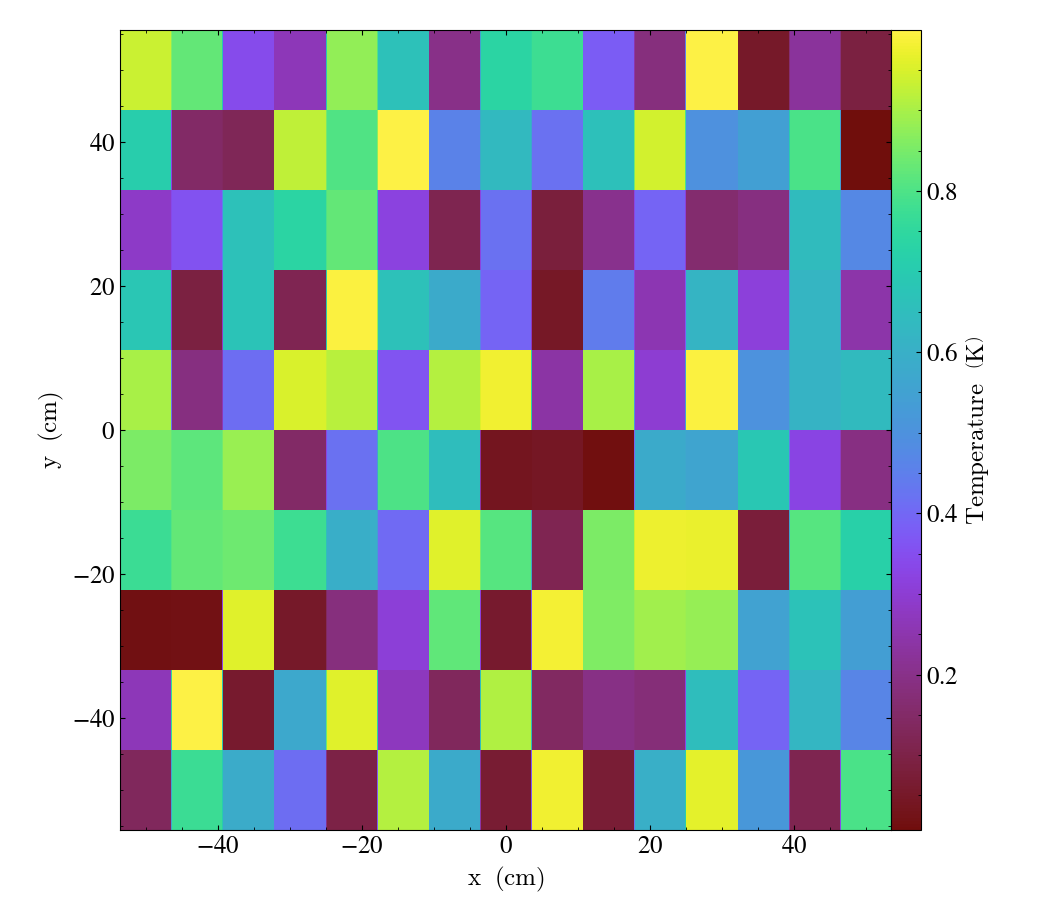

In [4]:
slc = yt.SlicePlot(yt_ds, "z", ("stream", "temperature"))
slc.set_log(("stream", "temperature"), False)
slc.show()

**Domain extent and units**

yt also has some useful attributes to quickly check the domain extents:

In [5]:
print(yt_ds.domain_center)

[0.5 0.5 0.5] code_length


In [6]:
print(yt_ds.domain_width)

[1.07142857 1.11111111 1.07142857] code_length


You'll notice that the output above are `unyt` arrays. The "code_length" refers to the representative length of your volume. You can view a unyt array with different unyts with:


In [7]:
print(yt_ds.domain_width.to('m'))

[1.07142857 1.11111111 1.07142857] m



The above sample dataset sets an attribute, `geospatial_vertical_units`:

In [8]:
ds.geospatial_vertical_units

'm'

which yt_xarray sets as the dataset `length_unit`:

In [9]:
yt_ds.length_unit

unyt_quantity(1., 'm')

without this attribute, you can set it explicitly so that yt will know the dimensions of your input coordinates:

In [10]:
yt_ds = ds.yt.load_grid(length_unit='km')

yt_xarray : [INFO ] 2023-02-06 12:24:08,945:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 12:24:08,946:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2023-02-06 12:24:09,045 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 12:24:09,046 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-02-06 12:24:09,047 Parameters: domain_left_edge          = [-0.03571429 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,048 Parameters: domain_right_edge         = [1.03571429 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,049 Parameters: cosmological_simulation   = 0


In [11]:
yt_ds.domain_width.to('m')

unyt_array([1071.42857143, 1111.11111111, 1071.42857143], 'm')

for more on units, unyt and yt, you can read more [here](https://yt-project.org/doc/analyzing/units.html). 



You also might notice that the domain width in the yt dataset is **slightly** larger than that in the xarray dataset:

In [12]:
print(yt_ds.domain_width)

[1.07142857 1.11111111 1.07142857] code_length


In [13]:
[ds.coords[dim].max().values.item() - ds.coords[dim].min().values.item() for dim in ds.dims]

[1.0, 1.0, 1.0]

This is related to how yt_xarray builds cells from node values, see [here](https://yt-xarray.readthedocs.io/en/latest/supported_grids.html) for an explanation.

### Loading a subset of fields

When you call `ds.yt.load_grid()` without arguments, it attempts to grab references to all of the available fields. If you only want to work with a subset of fields, you can supply the `fields` argument:

In [14]:
yt_ds = ds.yt.load_grid(fields=('temperature',))

yt_xarray : [INFO ] 2023-02-06 12:24:09,089:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 12:24:09,091:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2023-02-06 12:24:09,164 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 12:24:09,165 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-02-06 12:24:09,166 Parameters: domain_left_edge          = [-0.03571429 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,168 Parameters: domain_right_edge         = [1.03571429 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,169 Parameters: cosmological_simulation   = 0


One of the limitations to `yt_xarray`at present is that the fields loaded into yt must have the same dimensions. 

If for example, we had a dataset with a mix of 2d and 3d and 4d (space + time) variables:


In [15]:
fields = {'temperature': ('x', 'y', 'z'), 
          'pressure': ('x', 'y', 'z'), 
          'precip': ('x', 'y', 'time'), 
          'cumulative_precip': ('x', 'y')}
dims = {'x': (0,1,14), 'y': (0, 1, 10), 'z': (0, 1, 15), 'time': (0, 1, 11)}
ds = load_random_xr_data(fields, dims, length_unit='m')

and simply try to load the full dataset with 

```
ds.yt.load_grid()
```
then we will get an error due to the mismatching dimensions of the variables. In this case, we can load both the temperature and pressure fields with:

In [16]:
yt_ds = ds.yt.load_grid(fields=('temperature', 'pressure'))

yt_xarray : [INFO ] 2023-02-06 12:24:09,202:  Inferred geometry type is cartesian. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2023-02-06 12:24:09,203:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 12:24:09,204:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2023-02-06 12:24:09,266 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 12:24:09,267 Parameters: domain_dimensions         = [14 10 15]
yt : [INFO     ] 2023-02-06 12:24:09,268 Parameters: domain_left_edge          = [-0.03846154 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,269 Parameters: domain_right_edge         = [1.03846154 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,270 Parameters: cosmological_simulation   = 0


Furthermore, when loading variables with a time dimension, you should select the time index to load:

In [17]:
yt_ds = ds.yt.load_grid(fields=('precip',), sel_dict={'time':1})

yt_xarray : [INFO ] 2023-02-06 12:24:09,285:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 12:24:09,287:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2023-02-06 12:24:09,344 Parameters: current_time              = 0.1
yt : [INFO     ] 2023-02-06 12:24:09,345 Parameters: domain_dimensions         = [14 10  1]
yt : [INFO     ] 2023-02-06 12:24:09,347 Parameters: domain_left_edge          = [-0.03846154 -0.05555556 -0.5       ]
yt : [INFO     ] 2023-02-06 12:24:09,348 Parameters: domain_right_edge         = [1.03846154 1.05555556 0.5       ]
yt : [INFO     ] 2023-02-06 12:24:09,349 Parameters: cosmological_simulation   = 0


In [18]:
value, location = yt_ds.find_min(('stream', 'precip'))

yt : [INFO     ] 2023-02-06 12:24:09,494 min value is 1.64191e-02 at 0.9230769230769234 0.3333333333333334 0.0000000000000000


### Loading method and memory usage

When you use `ds.yt.load_grid`, by default yt_xarray will use references to the open xarray dataset handle internally within yt to avoid copying data. If your dataset fits into memory without a problem, then you can supply an additional `use_callable=False` argument to direct yt_xarray to instead work in memory on copies of data.

In [19]:
yt_ds = ds.yt.load_grid(fields=('temperature',), use_callable=False)

yt_xarray : [INFO ] 2023-02-06 12:24:09,500:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 12:24:09,502:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2023-02-06 12:24:09,552 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 12:24:09,553 Parameters: domain_dimensions         = [14 10 15]
yt : [INFO     ] 2023-02-06 12:24:09,554 Parameters: domain_left_edge          = [-0.03846154 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,556 Parameters: domain_right_edge         = [1.03846154 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 12:24:09,557 Parameters: cosmological_simulation   = 0


and data will be copied from the xarray dataset during creation of the yt dataset.